<a href="https://colab.research.google.com/github/changchuntzu0618/CS456-ANNandRL-DDPG/blob/Jessica/Miniproject_DDPG/DDPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**env.render(): visualize 

In [1]:
import gym
from helpers import NormalizedEnv, RandomAgent
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from mpl_toolkits.mplot3d import Axes3D
from pylab import*
import os
from tqdm import tqdm
# set colab to Trueif using google colab
colab=False

## 3. Heuristic Policy

In [2]:
# Implement a heuristic policy
class HeuristicPendulumAgent():
    def __init__(self, env):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.agent_name='HeuristicPendulumAgent'

    def get_agent_name(self):
        return self.agent_name
        

    def compute_action(self, state,fix_torque=1):
        #  print('fix_torque',fix_torque)
         # When the pendulum is in the lower half of the domain (x<0)
         if state[0]<0:
             # applies a fixed torque in the same direction as the pendulum’s angular velocity
             return fix_torque*np.sign(state[2])
         # When the pendulum is in the higher half of the domain (x>0)
         else:
             # applies a fixed torque in the  opposite direction as the pendulum’s angular velocity
             return -1*fix_torque*np.sign(state[2])

In [55]:
def DoState(env,agent,observation,total_reward_per_episode,agent_name='RandomAgent',fix_torque=0.1):
    if agent_name=='HeuristicPendulumAgent':
        action = agent.compute_action(observation,fix_torque)
    else:
        action = agent.compute_action(observation)
    # print('action:',action)
    normalized_env = NormalizedEnv(env)
    normalized_action = normalized_env.action(action)
    # print('normalized_action:',normalized_action)
    observation, reward, terminated, truncated, info = env.step(normalized_action)
    # print('observation:',observation)
    # print('reward:',reward)
    # print('terminated:',terminated)
    total_reward_per_episode += reward
    # print('total_reward:',total_reward)
    if terminated or truncated:
        observation, info = env.reset()

    return observation, info, total_reward_per_episode

def DoEpisode(env,agent,agent_name='RandomAgent',fix_torque=0.1,num_state=200) :
    observation, info = env.reset()
    total_reward_per_episode=0
    for _ in range(num_state):
        observation, info, total_reward_per_episode=DoState(env,agent,observation,total_reward_per_episode,agent_name,fix_torque)
        # print("total_reward_per_episode:",total_reward_per_episode)
    return total_reward_per_episode

total_reward: -627.2265883532475
average_reward: -627.2265883532475
total_reward: -1266.1454374935033
average_reward: -633.0727187467517
total_reward: -2624.168806404506
average_reward: -874.7229354681687
total_reward: -3811.934606873653
average_reward: -952.9836517184133
total_reward: -4776.95010503538
average_reward: -955.390021007076
total_reward: -5405.185016278633
average_reward: -900.8641693797722
total_reward: -6460.005788445832
average_reward: -922.857969777976
total_reward: -7929.938492438404
average_reward: -991.2423115548005
total_reward: -9478.839021752141
average_reward: -1053.204335750238
total_reward: -10855.066197977749
average_reward: -1085.5066197977749
total_reward: -989.0706840291793
average_reward: -989.0706840291793
total_reward: -2151.2731509591063
average_reward: -1075.6365754795531
total_reward: -3610.950216582076
average_reward: -1203.6500721940254
total_reward: -5068.594862489471
average_reward: -1267.1487156223677
total_reward: -6512.420546813386
average_rew

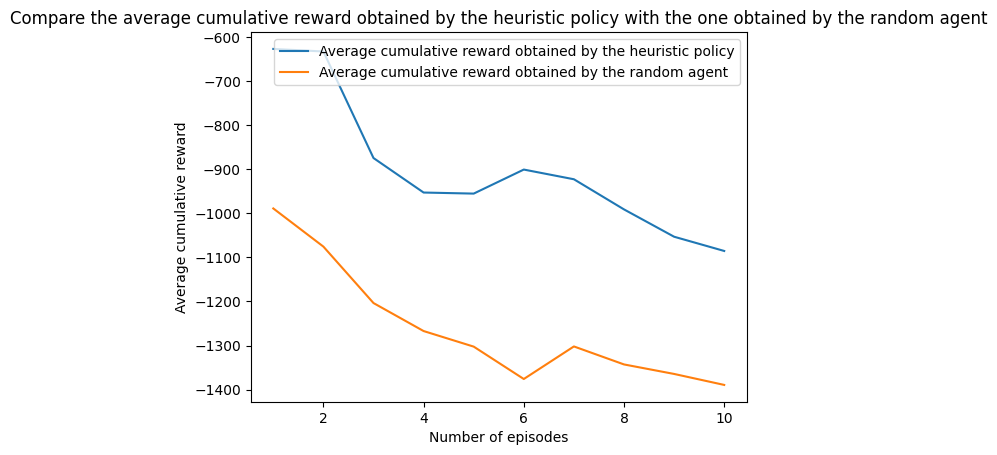

In [56]:
env = gym.make("Pendulum-v1")
num_episode=10
# Part 3: Report the average cumulative reward obtained by the heuristic policy
# draw plot to compare the average cumulative reward obtained by the heuristic policy 
# with the reward of the random agent
list_average_reward_HeuristicAgent=[]
total_episodes_reward_HeuristicAgent = 0
for episode in range(num_episode):
    agent = HeuristicPendulumAgent(env)
    total_reward_per_episode=DoEpisode(env, agent,agent.get_agent_name())
    total_episodes_reward_HeuristicAgent += total_reward_per_episode
    print('total_reward:', total_episodes_reward_HeuristicAgent)
    average_reward = total_episodes_reward_HeuristicAgent / (episode + 1)
    print('average_reward:', average_reward)
    list_average_reward_HeuristicAgent.append(average_reward)

list_average_reward_RandomAgent=[]
total_episodes_reward_RandomAgent = 0
for episode in range(num_episode):
    agent = RandomAgent(env)
    total_reward_per_episode=DoEpisode(env, agent)
    total_episodes_reward_RandomAgent += total_reward_per_episode
    print('total_reward:', total_episodes_reward_RandomAgent)
    average_reward = total_episodes_reward_RandomAgent / (episode + 1)
    print('average_reward:', average_reward)
    list_average_reward_RandomAgent.append(average_reward)

list_number_episodes = np.linspace(1,10,num=10)

plt.plot(list_number_episodes,list_average_reward_HeuristicAgent,label= 'Average cumulative reward obtained by the heuristic policy')
plt.plot(list_number_episodes,list_average_reward_RandomAgent,label= 'Average cumulative reward obtained by the random agent')
plt.xlabel('Number of episodes')
plt.ylabel('Average cumulative reward')
plt.legend()
plt.title('Compare the average cumulative reward obtained by the heuristic policy with the one obtained by the random agent')
plt.show()
env.close()

In [ ]:
# Part 3: Report the average cumulative reward obtained by the heuristic policy
# draw plot to show the impact of different amplitude of the fixed torque have on the reward
env = gym.make("Pendulum-v1")
num_episode=10
list_last_average_reward=[]
list_fix_torque=np.linspace(0.1, 2.0, num=20)
print(list_fix_torque)
for fix_torque in list_fix_torque:
    total_episodes_reward_HeuristicAgent=0
    for episode in range(num_episode):
        agent = HeuristicPendulumAgent(env)
        total_reward_per_episode=DoEpisode(env,agent,agent.get_agent_name(),fix_torque)
        total_episodes_reward_HeuristicAgent += total_reward_per_episode
        print('total_reward:', total_episodes_reward_HeuristicAgent)
        average_reward = total_episodes_reward_HeuristicAgent / (episode + 1)
        print('average_reward:', average_reward)
    list_last_average_reward.append(average_reward)
plt.plot(list_fix_torque,list_last_average_reward,'-o')
plt.xlabel("Fix Torque")
plt.ylabel("Average Reward (10 episodes)")
plt.title('Average Reward with differnt Fixed Torque (HeuristicPendulumAgent)')
plt.xticks(list_fix_torque)
plt.show()
env.close()

In [ ]:
import gym
env = gym.make("Pendulum-v1")
if colab:
  #if run in google colab
  observation = env.reset(seed=42)
else:
  #if run in own compuetr
  observation, info = env.reset(seed=42)

for _ in range(10):
    action = env.action_space.sample()
    if colab:
      observation, reward, terminated, info = env.step(action)
    else:
      observation, reward, terminated, truncated, info = env.step(action)
    print('observation:',observation)
    print('reward:',reward)
    # print('truncated:',truncated)
    # print(1-truncated)
    print(np.append(observation,reward))
    if not colab:
      if terminated or truncated:
          observation, info = env.reset()
env.close()

## 4. Q function of the heuristic policy 

In [8]:
import random
# Implement the Replay Buffer
class ReplayBuffer():
    def __init__(self, max_size):
        # amount: how many transitions are stored in the replay buffer now
        self.amount=0
        self.full_buffer=False
        # max_size: how many transitions replay buffer can store at most
        self.max_size = max_size
        # self.total_transition = []
        self.total_transition = np.zeros((max_size, 9))

    def add(self, transition):
        # transition: a tuple of (state, action, reward, next_state, trunc)
        if self.amount == self.max_size:
             # check if the replay buffer is full
            self.full_buffer=True
            # print('self.full_buffer:',self.full_buffer)
            self.amount=0

        if self.full_buffer:
            # print("The replay buffer is full.-> remove the oldest transition")
            # remove the oldest transition
            # print('self.total_transition[self.amount]:', self.total_transition[self.amount])
            self.total_transition[self.amount]=np.array(transition)
            # print('self.total_transition[self.amount]:', self.total_transition[self.amount])
        else:
            # add transition to replay buffer
            # print('self.total_transition[self.amount-1]:',self.total_transition[self.amount-1])
            # print('transition:',transition)
            # print('transition:',np.array(transition))
            self.total_transition[self.amount-1] = np.array(transition)
        self.amount+=1
        
        
    def sample(self, batch_size):
        # batch_size: how many transitions will be sampled
        # return a batch of transitions
        
        # check if the replay buffer is empty
        if len(self.total_transition) == 0:
            print("The replay buffer is empty.")
            return None
        
        # check if the replay buffer has enough transitions
        if len(self.total_transition) < batch_size:
            print("The replay buffer does not have enough transitions.")
            return None
        
        # sample batch_size transitions from the replay buffer randomly
        # return random.sample(self.total_transition, batch_size)
        random_index = random.sample(range(0, self.amount), batch_size)
        # assert np.sum(np.array(random_index)>self.amount)==0, "random_index should be less than 'self.amount'"
        # print('amount:',self.amount)
        # print('random_index:',random_index)
        return self.total_transition[random_index]
    def __len__(self):
        return self.amount

In [4]:
# Implement the class QNetwork
class QNetwork(nn.Module):
    def __init__(self, input_dim=4, output_dim=1, hidden_dim=32):
        super(QNetwork, self).__init__()
        # input_dim: dimension of the input -> 3 elements of the state and 1 of the action
        # hidden_dim: dimension of one hidden layer -> 32 nodes
        # output_dim: dimension of action -> a scalar value (the expected cumulative reward)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, state):
        # state: state -> 3 elements of the state and 1 of the action
        # return expected cumulative reward 
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x   

In [5]:
# Implement the 1-step TD-learning rule for the QNetwork
def train_QNetwork(Q_network,Q_target,normalized_env,agent, batch, gamma, optimizer,fix_torque=1,policy_network=None,deterministic=None):
    # print("HERE TRAIN")
    # Q_network: Q Network
    # agent: policy use for action selection
    # batch: a batch of transitions
    # gamma: discount factor
    # optimizer: optimizer
    # fix_torque: fixed torque for HeuristicPendulumAgent
    
    # unpack the batch of transitions
    # input_batch:put together 3 elements of the state and 1 of the action
    # print('trainsition:',batch[0])
    input_batch=torch.tensor([np.append(transition[0:3],transition[3]) for transition in batch], dtype=torch.float)
    # print the shape of input batch
    # print('input_batch:',input_batch.shape)
    # print('input_batch:',input_batch[0])
    reward_batch = torch.tensor([transition[4] for transition in batch], dtype=torch.float)
    # print('reward_batch:',reward_batch.shape)
    # print('reward_batch:',reward_batch[0])
    reward_batch=torch.unsqueeze(reward_batch, 1)
    # print('reward_batch:',reward_batch.shape)
    # print('reward_batch:',reward_batch[0])
    if agent.agent_name =='HeuristicPendulumAgent':
        # print('agent name',agent.agent_name)
        target_batch=torch.tensor([np.append(transition[5:8], agent.compute_action(transition[5:8],fix_torque)) for transition in batch], dtype=torch.float)
    else:
        target_batch=torch.tensor([np.append(transition[5:8], agent.compute_action(policy_network,transition[5:8],deterministic)) for transition in batch], dtype=torch.float)
    # print('target_batch:',target_batch[0])
    # print('target_batch:',target_batch.shape)
    trunc_batch=torch.tensor([transition[8] for transition in batch], dtype=torch.float)
    # print('trunc_batch:',trunc_batch.shape)
    # print('trunc_batch:',trunc_batch[0])

    # clear the gradients of the optimizer
    optimizer.zero_grad()

    # compute the Q values of the current state + action pair
    # Q_network.train()
    Q_values = Q_network(input_batch)
    
    # The target should not be differentiated, i.e., wrap it in a with torch.no grad()
    # TODO: check with TA if it is correct
    with torch.no_grad():
        # Q_network.eval()
        # compute the Q values of the next state + next action pair
        Q_next_values = Q_target(target_batch)

    # print the shape of reward batch, gamma, Q_next_values, trunc_batch
    # print('reward_batch:',reward_batch.shape)
    # print('gamma:',gamma.shape)
    # print('Q_next_values:',Q_next_values.shape)
    # print('1-trunc_batch:',torch.unsqueeze((1 - trunc_batch), 1).shape)
    # print('Q*truc:',(Q_next_values * torch.unsqueeze((1 - trunc_batch), 1)).shape)
    Q_target_values = reward_batch + gamma * Q_next_values * torch.unsqueeze((1 - trunc_batch), 1)
    # if not last_step:
    #     # compute the target Q values
    #     Q_target_values = reward_batch + gamma * Q_next_values# * (1 - trunc_batch)
    # else:
    #     Q_target_values = reward_batch
    # print('Q_values:',Q_values.requires_grad)
    # print('Q_next_values:',Q_next_values.requires_grad)
    # print('Q_target_values:',Q_target_values.requires_grad)
    # for param, target_param in zip(Q_network.parameters(), Q_target.parameters()):
    #     print("TRAIN param:",param[0],param[0].requires_grad,"target_param:",target_param[0],target_param[0].requires_grad)
    #     break
        
    # compute the loss
    loss = F.mse_loss(Q_values.view(-1, 1), Q_target_values.view(-1, 1))
    # print('loss:',loss.requires_grad)
    
    # compute the gradients of the loss
    loss.backward()
    # # show the gradients of the parameters in the Q network
    # print("Q_network:",Q_network.fc1.weight.grad[0])
    # try:
    #     print("Q_target:",Q_target.fc1.weight.grad[0])
    # except:
    #     pass
    
    # update the weights of the Q network
    optimizer.step()
    
    return loss.item(), Q_network

In [9]:
# Write a loop in which the HeuristicPendulumAgent collects experience and stores it in the replay
# buffer. At each step, sample a batch of transitions from the replay buffer (uniformly at random,
# batch size 128) and feed them to the 1-step TD-learning rule that you have implemented. At each
# step, store the loss of the Q network. 
import copy
env = gym.make("Pendulum-v1")
num_episode=200
batch_size=128
buffer_size=10000
gamma=0.99
learning_rate=1e-4
sum_loss=0
list_average_loss=[]
# initialize the Q network 
Q_network=QNetwork()
Q_target=QNetwork()
Q_target.load_state_dict(Q_network.state_dict())
# define a optimizer for the QNetwork
optimizer = torch.optim.Adam(Q_network.parameters(), learning_rate)
# define replay buffer
replay_buffer=ReplayBuffer(buffer_size)
# define agent
agent = HeuristicPendulumAgent(env)
num_step=200

normalized_env = NormalizedEnv(env)
print('Start training...')
for episode in tqdm(range(num_episode)):
    # print('episode number:',episode,'/',num_episode,'...')
    # initialize the sum_loss for each episode
    sum_loss=0
    last_step=False
    # renew the environment for every episode
    if colab:
      # if running in google colab
      state= env.reset()
    else:
      # if running in own computer
      state, info = env.reset()
    
    for step in range(num_step):
        # print('step:',step,'/',num_step,'...')
        
        # add transition to replay buffer, and kick out the old one if the buffer is full
        action = agent.compute_action(state)
        # print('action:',action)
        normalized_action = normalized_env.action(action)
        # print('normalized_action:',normalized_action)
        
        next_state, reward, terminated,truncated, info = env.step(normalized_action)
        transition=np.concatenate((state, action, reward, next_state, truncated),axis=None)
        # print('transition:',transition)
        replay_buffer.add(transition)
        state=next_state.copy()

        if replay_buffer.__len__() < batch_size:
            # print('amount of trainsitions:',replay_buffer.__len__())
            print("The replay buffer does not have enough transitions.")
            continue
    
        # sample a batch of transitions from the replay buffer
        batch = replay_buffer.sample(batch_size)


        # train the Q network
        loss,Q_network=train_QNetwork(Q_network,Q_target,normalized_env,agent, batch, gamma, optimizer,fix_torque=1)
        # print('loss:',loss)
        # if loss is not None:
        sum_loss+=loss
        # for param, target_param in zip(Q_network.parameters(), Q_target.parameters()):
        #         print("BEFORE param:",param[0],param[0].requires_grad,"target_param:",target_param[0],target_param[0].requires_grad)
        #         break
       
        Q_target.load_state_dict(Q_network.state_dict())
        # print("Q_network:",Q_network.fc1.weight.grad[0])

        # for param, target_param in zip(Q_network.parameters(), Q_target.parameters()):
        #         print("AFTER param:",param[0],param[0].requires_grad,"target_param:",target_param[0],target_param[0].requires_grad)
        #         break

    average_loss=sum_loss/num_step
    # print('average_loss:',average_loss)
    list_average_loss.append(average_loss)
print('Finishing training!')
print('Save the model...')
# save the model with path name with real-time date and time
save_path= os.path.join('trained_model','Q_network_heuristic_policy_'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'_ep'+str(num_episode)+'.pth')
torch.save(Q_network.state_dict(), save_path)
print('Model save to ',save_path,' !')

list_number_episodes = np.linspace(1,num_episode,num = num_episode)
plt.plot(list_number_episodes,list_average_loss)
plt.xlabel('Number of episodes')
plt.ylabel('Average loss per episode')
plt.title('Average loss per episode obtained by the heuristic policy')
print('Save the figure...')
image_path=os.path.join('figure','4_TrainingCruveofQnetwork__'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'_ep'+str(num_episode)+'.png')
plt.savefig(image_path)
plt.show()

env.close()


Start training...


  0%|          | 0/200 [00:00<?, ?it/s]

The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay b

C:\Users\CHANGCHUNTZU\AppData\Local\Temp\ipykernel_44972\1409793701.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  input_batch=torch.tensor([np.append(transition[0:3],transition[3]) for transition in batch], dtype=torch.float)
  4%|▍         | 9/200 [00:06<02:18,  1.38it/s]


KeyboardInterrupt: 

In [ ]:
# get the model weight
model_path=os.path.join('trained_model','Q_network_heuristic_policy_xxx.pth')
# initialize the Q network with the stored model
Q_network=QNetwork()
Q_network.load_state_dict(torch.load(model_path))

In [ ]:
# plot polar heatmap 

# training the Q_Network
import copy
env = gym.make("Pendulum-v1")
print('here')
num_episode=10
batch_size=128
buffer_size=10000
gamma=0.99
learning_rate=1e-4
# initialize the Q network 
Q_network=QNetwork()
Q_target=QNetwork()
Q_target.load_state_dict(Q_network.state_dict())
# define a optimizer for the QNetwork
optimizer = torch.optim.Adam(Q_network.parameters(), learning_rate)
# define replay buffer
replay_buffer=ReplayBuffer(buffer_size)
# define agent
agent = HeuristicPendulumAgent(env)
num_step=200

normalized_env = NormalizedEnv(env)
print('Start training...')
for episode in range(num_episode):
    print('episode number:',episode,'/',num_episode,'...')
    # renew the environment for every episode
    state, info = env.reset()
    
    for step in range(num_step):
        action = agent.compute_action(state)
        normalized_action = normalized_env.action(action)
        next_state, reward, terminated, truncated, info = env.step(normalized_action)
        transition=(state, normalized_action, reward, next_state, truncated)
        replay_buffer.add(transition)
        state=next_state

        if len(replay_buffer) < batch_size:
            print("The replay buffer does not have enough transitions.")
            continue
    
        # sample a batch of transitions from the replay buffer
        batch = replay_buffer.sample(batch_size)

        loss,Q_network=train_QNetwork(Q_network,Q_target,normalized_env,agent, batch, gamma, optimizer)
        Q_target.load_state_dict(Q_network.state_dict())
print('finished training...')

#action_values= np.random.uniform(-2, 2,5)
#velocity_values= np.random.uniform(-5, 5,5)
action_values= [-2,-1,0,1,2]
velocity_values=[-5,-2.5,0,2.5,5]
angles=np.linspace(0,2*np.pi,360)
angles_cosinus=[np.cos(ang) for ang in angles]
angles_sinus=[np.sin(ang) for ang in angles]


for j in range(5):
    Q_network_before_training=QNetwork()
    states=[np.append(np.append(angles_cosinus[i],angles_sinus[i]),velocity_values[j]) for i in range(360)]
    #print('states= ', states)
    inputs=torch.tensor([np.append(states[i],action_values[j]) for i in range(360)], dtype=torch.float32)
    print ('*******************************************************************************************')
    print('(action',j+1,'=',action_values[j], ', velocity',j+1,'=',velocity_values[j], ')')
    Q_values_before_training=Q_network_before_training(inputs)
    Q_values_before_training=Q_values_before_training.detach().numpy()
    print ('before training!')
    # print('Q_values before training = ', Q_values_before_training)
    Q_Matrix_before_training=Q_values_before_training
    for i in range(359):
        Q_Matrix_before_training=np.column_stack((Q_Matrix_before_training,Q_values_before_training))
    fig_before_training = plt.figure()
    rad=np.linspace(0,5,360)
    r,th=np.meshgrid(rad,angles)
    ax_before_training = fig_before_training.add_subplot(111, polar=True)
    p_before_training = ax_before_training.pcolormesh(th, r, Q_Matrix_before_training)
    fig_before_training.colorbar(p_before_training)
    plt.show()

    Q_values_after_training = Q_network(inputs)
    Q_values_after_training = Q_values_after_training.detach().numpy()
    print ('after training!')
    # print('Q_values after training = ', Q_values_after_training)
    Q_Matrix_after_training = Q_values_after_training
    for i in range(359):
        Q_Matrix_after_training=np.column_stack((Q_Matrix_after_training,Q_values_after_training))
    fig_after_training = plt.figure()
    ax_after_training = fig_after_training.add_subplot(111, polar=True)
    p_after_training = ax_after_training.pcolormesh(th, r, Q_Matrix_after_training)
    fig_after_training.colorbar(p_after_training)
    plt.show()


here
Start training...
episode number: 0 / 1000 ...


ValueError: ignored

## Part 5 Minimal implementation of DDPG

In [10]:
# PolicyNetwork
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim=3, output_dim=1, hidden_dim=32):
        super(PolicyNetwork, self).__init__()
        # input_dim: dimension of the input -> 3 elements of the state
        # hidden_dim: dimension of one hidden layer -> 32 nodes
        # output_dim: dimension of action -> a scalar (action)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, state):
        # state: state -> 3 elements of the state
        # return action 
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        # apply tanh to restrict the action in the range [-1, 1]
        x = F.tanh(self.fc3(x))

        return x

In [11]:
#GaussianActionNoise
class GaussianActionNoise():
    def __init__(self, sigma):
        self.sigma = sigma
        self.mu=0
    def get_noisy_action(self,action):
        noise = np.random.normal(self.mu,self.sigma)
        noisy_action = action + noise
        # clip the noisy action to be in the range [-1, 1]
        noisy_action = np.clip(noisy_action, -1, 1)
        return noisy_action

In [12]:
# DDPGAgent
class DDPGAgent():
    def __init__(self,env,sigma):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.agent_name='DDPGAgent'
        self.action_noise=GaussianActionNoise(sigma)

    def compute_action(self,policy_network,state,deterministic=True):
        # deterministic: regulates whether to add random noise to the action or not
        with torch.no_grad():
            # convert state to tensor
            state = torch.tensor(state, dtype=torch.float)
            # compute the action
            action = policy_network(state)
            if not deterministic:
                # add random noise to the action
                action = self.action_noise.get_noisy_action(action)
            # convert action to numpy array
            action = action.numpy()
        return action

In [17]:
# Train PolicyNetwork
def train_PolicyNetwork(policy_network,Q_network, batch, optimizer):
    # print("HERE TRAIN")
    # optimizer: optimizer
    
    # unpack the batch of transitions
    state_batch=torch.tensor([transition[0:3] for transition in batch], dtype=torch.float)

    # clear the gradients of the optimizer
    optimizer.zero_grad()

    
    # policy_network: policy use for action selection
    predicted_action = policy_network(state_batch)
    # with torch.no_grad():
    # compute the Q values of the current state + predicted action pair
    Q_values = Q_network(torch.cat((state_batch,predicted_action),1))
        
    # print("Q_values:",Q_values)
    # print(' -Q_values.mean():', -Q_values.mean())
    # compute the loss
    loss = -Q_values.mean()
    
    
    # compute the gradients of the loss
    loss.backward()
    
    # update the weights of the Q network
    optimizer.step()
    
    return loss.item(), policy_network, predicted_action

In [19]:
env = gym.make("Pendulum-v1")
num_episode=200
num_step=200
batch_size=128
buffer_size=100000
gamma=0.99
learning_rate=1e-4
sigma=0.3
deterministic=False
list_average_loss_Q_network=[]
list_average_loss_policy_network=[]
list_reward=[]

# initialize the Q network 
Q_network=QNetwork()
Q_target=QNetwork()
# define policy network
policy_network=PolicyNetwork()
Q_target.load_state_dict(Q_network.state_dict())
# define a optimizer for the QNetwork
optimizer = torch.optim.Adam(Q_network.parameters(), learning_rate)
# define replay buffer
replay_buffer=ReplayBuffer(buffer_size)
# define agent
agent = DDPGAgent(env,sigma)

print('Start training...')
for episode in tqdm(range(num_episode)):
    sum_reward=0
    # print('episode number:',episode,'/',num_episode,'...')
    # initialize the sum_loss for each episode
    sum_loss_Q_network=0
    sum_loss_policy_network=0
    # renew the environment for every episode
    state, info = env.reset()
    normalized_env = NormalizedEnv(env)
    last_step=False
    for step in range(num_step):
        # print('step:',step,'/',num_step,'...')
        
        # add transition to replay buffer, and kick out the old one if the buffer is full
        # add noise to action when deterministic=False
        action = agent.compute_action(policy_network,state,deterministic)
        # print('action:',action)
        normalized_action = normalized_env.action(action)
        # print('normalized_action:',normalized_action)
        next_state, reward, terminated, truncated, info = env.step(normalized_action)
        transition=np.concatenate((state, action, reward, next_state, truncated),axis=None)
        replay_buffer.add(transition)
        state=next_state

        if replay_buffer.__len__() < batch_size:
            print("The replay buffer does not have enough transitions.")
            continue
    
        # sample a batch of transitions from the replay buffer
        batch = replay_buffer.sample(batch_size)

        # train the policy_network
        loss_policy_network,policy_network,predict_actions=train_PolicyNetwork(policy_network,Q_network, batch, optimizer)
        predict_rewards=0
        for batch_idx in range(batch_size):
            normalized_predict_action = normalized_env.action(predict_actions[batch_idx].item())
            _, predict_reward, _, _, _ = env.step(normalized_predict_action)
            predict_rewards+=predict_reward
        avg_predict_reward=predict_rewards/batch_size
        sum_reward+=avg_predict_reward

        # if it is last step, set last_step=True
        if step==num_step-1:
            last_step=True

        # TODO: check with TA if it is correct 
        # loss_Q_network,Q_network=train_QNetwork(Q_network,Q_target,normalized_env,agent, batch, gamma, optimizer,fix_torque=None,policy_network=policy_network,deterministic=deterministic)
        loss_Q_network,Q_network=train_QNetwork(Q_network,Q_target,normalized_env,agent, batch, gamma, optimizer,fix_torque=None,policy_network=policy_network,deterministic=deterministic)
        if loss_Q_network is not None:
            sum_loss_Q_network+=loss_Q_network
        if loss_policy_network is not None:   
            sum_loss_policy_network+=loss_policy_network
        Q_target.load_state_dict(Q_network.state_dict())
        
    average_loss_Q_network=sum_loss_Q_network/num_step
    average_loss_policy_network=sum_loss_policy_network/num_step
    list_average_loss_Q_network.append(average_loss_Q_network)
    list_average_loss_policy_network.append(average_loss_policy_network)
    list_reward.append(sum_reward)
print('Finishing training!')
# print('Save the model...')
# # save the model with path name with real-time date and time
# save_path_Q= os.path.join('trained_model','5_Qnetwork_DDPG_'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'_ep'+str(num_episode)+'.pth')
# torch.save(Q_network.state_dict(), save_path_Q)
# print('Qnetwork Model save to ',save_path_Q,' !')
# save_path_Policy= os.path.join('trained_model','5_Policynetwork_DDPG_'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'_ep'+str(num_episode)+'.pth')
# torch.save(policy_network.state_dict(), save_path_Policy)
# print('Policy network Model save to ',save_path_Policy,' !')

list_number_episodes = np.linspace(1,num_episode,num = num_episode)
plt.plot(list_number_episodes,list_average_loss_Q_network, label='Average loss obtained by the Q-Network')
plt.plot(list_number_episodes,list_average_loss_policy_network, label='Average loss obtained by the policy Network')
plt.xlabel('Number of episodes')
plt.ylabel('Average loss per episode')
plt.title('Average loss obtained by the Q-Network and the policy Network')
plt.legend()
print('Save the figures...')
image_path=os.path.join('figure','5_AverageLoss_'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'_ep'+str(num_episode)+'.png')
plt.savefig(image_path)
plt.show()
plt.figure()
plt.plot(list_number_episodes,list_reward)
plt.xlabel('Number of episodes')
plt.ylabel('Accumulated reward')
plt.title('Accumulated reward per episode')
print('Save the figures...')
image_path=os.path.join('figure','5_AccumulatedRewardPerEpisode__'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'_ep'+str(num_episode)+'.png')
plt.savefig(image_path)
plt.show()
env.close()

Start training...


  0%|          | 0/200 [00:00<?, ?it/s]

The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay buffer does not have enough transitions.
The replay b

  4%|▍         | 8/200 [01:49<43:39, 13.64s/it]


KeyboardInterrupt: 

Start testing...
episode number: 0 / 100 ...
episode number: 1 / 100 ...
episode number: 2 / 100 ...
episode number: 3 / 100 ...
episode number: 4 / 100 ...
episode number: 5 / 100 ...
episode number: 6 / 100 ...
episode number: 7 / 100 ...
episode number: 8 / 100 ...
episode number: 9 / 100 ...
episode number: 10 / 100 ...
episode number: 11 / 100 ...
episode number: 12 / 100 ...
episode number: 13 / 100 ...
episode number: 14 / 100 ...
episode number: 15 / 100 ...
episode number: 16 / 100 ...
episode number: 17 / 100 ...
episode number: 18 / 100 ...
episode number: 19 / 100 ...
episode number: 20 / 100 ...
episode number: 21 / 100 ...
episode number: 22 / 100 ...
episode number: 23 / 100 ...
episode number: 24 / 100 ...
episode number: 25 / 100 ...
episode number: 26 / 100 ...
episode number: 27 / 100 ...
episode number: 28 / 100 ...
episode number: 29 / 100 ...
episode number: 30 / 100 ...
episode number: 31 / 100 ...
episode number: 32 / 100 ...
episode number: 33 / 100 ...
episode

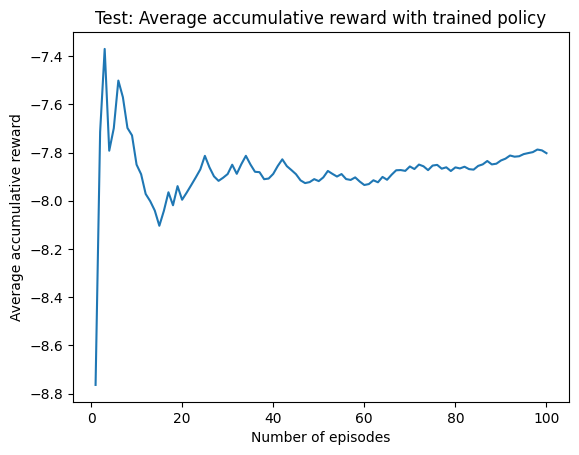

In [ ]:
# Excute Test with the trained model

env = gym.make("Pendulum-v1")
num_episode=100
num_step=200
sigma=0.3
deterministic=True
episode_accumulated_reward=0
list_avg_accumulated_reward=[]

# get the model weight
policy_model_path=os.path.join('trained_model','5_Policynetwork_DDPG_202305042005_ep10.pth')
qnetwork_model_path=os.path.join('trained_model','5_Qnetwork_DDPG_202305042005_ep10.pth')
# initialize the Q network with the stored model
Q_network=QNetwork()
Q_network.load_state_dict(torch.load(qnetwork_model_path))
# initialize the policy network with the stored model
policy_network=PolicyNetwork()
policy_network.load_state_dict(torch.load(policy_model_path))

# define agent
agent = DDPGAgent(env,sigma)

print('Start testing...')
for episode in range(num_episode):
    sum_reward=0
    print('episode number:',episode,'/',num_episode,'...')
    # initialize the sum_loss for each episode
    sum_loss_Q_network=0
    sum_loss_policy_network=0
    # renew the environment for every episode
    state, info = env.reset()
    normalized_env = NormalizedEnv(env)
    with torch.no_grad():
        for step in range(num_step):
            # print('step:',step,'/',num_step,'...')
            
            # create new transition/data
            # do not add noise to action by deterministic=True
            action = agent.compute_action(policy_network,state,deterministic)
            # print('action:',action)
            normalized_action = normalized_env.action(action)
            # print('normalized_action:',normalized_action)
            next_state, reward, terminated, truncated, info = env.step(normalized_action)
            state=next_state
        
            # unpack the batch of transitions
            # only 1 btach here since here is testing
            state_batch=torch.tensor([state], dtype=torch.float)

            # policy_network: policy use for action selection
            predicted_action = policy_network(state_batch)
            
            # print('predicted_action:',predicted_action.item())
            normalized_predict_action = normalized_env.action(predicted_action.item())
            _, predict_reward, _, _, _ = env.step(normalized_predict_action)
            
            sum_reward+=predict_reward
        episode_accumulated_reward+=sum_reward/num_step
        list_avg_accumulated_reward.append(episode_accumulated_reward/(episode+1))

list_number_episodes = np.linspace(1,num_episode,num = num_episode)
plt.plot(list_number_episodes,list_avg_accumulated_reward)
plt.xlabel('Number of episodes')
plt.ylabel('Average accumulative reward')
plt.title('Test: Average accumulative reward with trained policy')
print('Save the figures...')
image_path=os.path.join('figure','5_TestAvgAccumulativeReward__'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'_ep'+str(num_episode)+'.png')
plt.savefig(image_path)
plt.show()
env.close()



In [ ]:
# polar heatmap 
env = gym.make("Pendulum-v1")
num_episode=10 #100
num_step=200
batch_size=128
buffer_size=100000
gamma=0.99
learning_rate=1e-4
sigma=0.3
deterministic=False
# initialize the Q network 
Q_network=QNetwork()
Q_target=QNetwork()
# define policy network
policy_network=PolicyNetwork()
Q_target.load_state_dict(Q_network.state_dict())
# define a optimizer for the QNetwork
optimizer = torch.optim.Adam(Q_network.parameters(), learning_rate)
# define replay buffer
replay_buffer=ReplayBuffer(buffer_size)
# define agent
agent = DDPGAgent(env,sigma)

print('Start training...')
for episode in range(num_episode):
    print('episode number:',episode,'/',num_episode,'...')
    # renew the environment for every episode
    state, info = env.reset()
    normalized_env = NormalizedEnv(env)
    for step in range(num_step):
        # print('step:',step,'/',num_step,'...')
        
        # add transition to replay buffer, and kick out the old one if the buffer is full
        # add noise to action when deterministic=False
        action = agent.compute_action(policy_network,state,deterministic)
        normalized_action = normalized_env.action(action)
        next_state, reward, terminated, truncated, info = env.step(normalized_action)
        transition=(state, normalized_action, reward, next_state, truncated)
        replay_buffer.add(transition)
        state=next_state

        if len(replay_buffer) < batch_size:
            print("The replay buffer does not have enough transitions.")
            continue
    
        # sample a batch of transitions from the replay buffer
        batch = replay_buffer.sample(batch_size)

        # train the policy_network
        loss_policy_network,policy_network,predict_actions=train_PolicyNetwork(policy_network,Q_network, batch, optimizer) 
        loss_Q_network,Q_network=train_QNetwork(Q_network,Q_target,normalized_env,agent, batch, gamma, optimizer,fix_torque=None,policy_network=policy_network,deterministic=deterministic)
        Q_target.load_state_dict(Q_network.state_dict())
        
#action_values= np.random.uniform(-2, 2,5)
#velocity_values= np.random.uniform(-5, 5,5)
action_values= [-2,-1,0,1,2]
velocity_values=[-5,-2.5,0,2.5,5]
angles=np.linspace(0,2*np.pi,360)
angles_cosinus=[np.cos(ang) for ang in angles]
angles_sinus=[np.sin(ang) for ang in angles]


for j in range(5):
    Q_network_before_training=QNetwork()
    states=[np.append(np.append(angles_cosinus[i],angles_sinus[i]),velocity_values[j]) for i in range(360)]
    #print('states= ', states)
    inputs=torch.tensor([np.append(states[i],action_values[j]) for i in range(360)], dtype=torch.float32)
    print ('*******************************************************************************************')
    print('(action',j+1,'=',action_values[j], ' , velocity',j+1,'=',velocity_values[j], ')')
    Q_values_before_training=Q_network_before_training(inputs)
    Q_values_before_training=Q_values_before_training.detach().numpy()
    print ('before training!')
    # print('Q_values before training = ', Q_values_before_training)
    Q_Matrix_before_training=Q_values_before_training
    for i in range(359):
        Q_Matrix_before_training=np.column_stack((Q_Matrix_before_training,Q_values_before_training))
    fig_before_training = plt.figure()
    rad=np.linspace(0,5,360)
    r,th=np.meshgrid(rad,angles)
    ax_before_training = fig_before_training.add_subplot(111, polar=True)
    p_before_training = ax_before_training.pcolormesh(th, r, Q_Matrix_before_training)
    fig_before_training.colorbar(p_before_training)
    plt.show()

    Q_values_after_training = Q_network(inputs)
    Q_values_after_training = Q_values_after_training.detach().numpy()
    print ('after training!')
    # print('Q_values after training = ', Q_values_after_training)
    Q_Matrix_after_training = Q_values_after_training
    for i in range(359):
        Q_Matrix_after_training=np.column_stack((Q_Matrix_after_training,Q_values_after_training))
    fig_after_training = plt.figure()
    ax_after_training = fig_after_training.add_subplot(111, polar=True)
    p_after_training = ax_after_training.pcolormesh(th, r, Q_Matrix_after_training)
    fig_after_training.colorbar(p_after_training)
    plt.show()

# Part 6 : Target networks

In [ ]:
# DDPGAgent
class DDPGAgent():
    def __init__(self,env,sigma,tau):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.agent_name='DDPGAgent'
        self.action_noise=GaussianActionNoise(sigma)

        self.actor_network = PolicyNetwork()
        self.actor_target = PolicyNetwork()
        self.actor_target.load_state_dict(self.actor_network.state_dict())

        self.critic_network = QNetwork()
        self.critic_target = QNetwork()
        self.critic_target.load_state_dict(self.critic_network.state_dict())

        self.tau = tau

    def compute_action(self,policy_network,state,deterministic=True):
        # deterministic: regulates whether to add random noise to the action or not
        with torch.no_grad():
            # convert state to tensor
            state = torch.tensor(state, dtype=torch.float)
            # compute the action
            action = policy_network(state)
            if not deterministic:
                # add random noise to the action
                action = self.action_noise.get_noisy_action(action)
            # convert action to numpy array
            action = action.numpy()
        return action
    
    def update_target_params(self):
        # update the parameters of networks
        with torch.no_grad():
            # for param, target_param in zip(self.critic_network.parameters(), self.critic_target.parameters()):
            #        print("param:",param,"target_param:",target_param)
            
            for param, target_param in zip(self.critic_network.parameters(), self.critic_target.parameters()):
                    target_param.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            # for param, target_param in zip(self.critic_network.parameters(), self.critic_target.parameters()):
            #         print("param:",param,"target_param:",target_param)
            
            
            for param, target_param in zip(self.actor_network.parameters(), self.actor_target.parameters()):
                target_param.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
    


In [ ]:
env = gym.make("Pendulum-v1")
agent=DDPGAgent(env,sigma=1,tau=1)
agent.update_target_params()

param: Parameter containing:
tensor([[ 0.1337,  0.2907, -0.4738, -0.1623],
        [ 0.2650, -0.2635,  0.2133, -0.2514],
        [ 0.4840, -0.0874,  0.2426, -0.3500],
        [ 0.4387, -0.2060, -0.0940,  0.3357],
        [-0.1981,  0.4028,  0.3692,  0.4964],
        [ 0.4803, -0.3444, -0.3656, -0.0080],
        [-0.1088,  0.4704,  0.0819,  0.1799],
        [-0.2702, -0.3917, -0.2243,  0.1432],
        [-0.3620,  0.4207,  0.0549, -0.4528],
        [-0.1462,  0.4691, -0.3018, -0.0072],
        [ 0.1861,  0.1762,  0.2910, -0.3104],
        [ 0.0869,  0.2508, -0.4310,  0.1382],
        [ 0.0921, -0.4963, -0.3537,  0.3927],
        [-0.3188, -0.2684, -0.1968, -0.1823],
        [-0.1618, -0.1758, -0.2084, -0.1656],
        [-0.3481,  0.2312, -0.1967, -0.2341],
        [ 0.2853,  0.4237,  0.3119,  0.3537],
        [-0.0530,  0.1259, -0.0856,  0.2233],
        [ 0.4906,  0.4377,  0.2701,  0.3642],
        [-0.2194,  0.1395,  0.0486,  0.4651],
        [ 0.4211,  0.1656,  0.1872, -0.2973],
     